# OpenBB Functionality Research
## 3. Government
- **EU Yield Curve**
- **TIPS Yields**
- **Treasury Auctions**
- **Treasury Prices**
- **Treasury Rates**
- **US Yield Curve**
- **Yield Curve**


In [2]:
from openbb import obb

In [ ]:
# OpenBB Login
obb.account.login(email="email", password="pw", remember_me=True)

# FRED API Key
obb.user.credentials.fred_api_key = "API-KEY"

Taking a deeper look at the government class, I am interested in the yield curve and how we can extract this

For this I will use FRED since I have an API key already and I will want to extract the US yield curve.
After a lot of trial and error and reading of documentation, I extracted the below:


- I removed the Index because I wanted better access to the date

In [4]:
import pandas as pd

us_yield_curve = obb.fixedincome.government.yield_curve(provider='fred', country='united_states')
df = us_yield_curve.to_df(index=False)
df

,date,maturity,rate
0,2024-11-07,month_1,0.0469
1,2024-11-07,month_3,0.0463
2,2024-11-07,month_6,0.0440
3,2024-11-07,year_1,0.0428
4,2024-11-07,year_2,0.0421
5,2024-11-07,year_3,0.0413
6,2024-11-07,year_5,0.0417
7,2024-11-07,year_7,0.0425
8,2024-11-07,year_10,0.0431
9,2024-11-07,year_20,0.0462


The output (after converting to a df for easier readability) has the date as an index and they state the maturities as a string of either the number of months or years.

I want the actual dates so we can build a simple yield curve

In [5]:
def get_maturity_date(maturity_str, start_date):
    """
    The data that is returned uses maturties in the form of month_1/year_1
    Because of this I will need to strip the string and convert it into a date
    """
    period = int(maturity_str.split('_')[1])
    if 'month' in maturity_str:
        return start_date + pd.DateOffset(months=period)
    elif 'year' in maturity_str:
        return start_date + pd.DateOffset(years=period)
    return start_date 

### Running the above gives me:

In [6]:
df["maturity"] = df.apply(lambda row: get_maturity_date(row["maturity"], pd.to_datetime(row['date'])),axis=1)
df = df[['maturity','rate']] # Cleaning up the df
df

,maturity,rate
0,2024-12-07,0.0469
1,2025-02-07,0.0463
2,2025-05-07,0.0440
3,2025-11-07,0.0428
4,2026-11-07,0.0421
5,2027-11-07,0.0413
6,2029-11-07,0.0417
7,2031-11-07,0.0425
8,2034-11-07,0.0431
9,2044-11-07,0.0462


Later on I want to get to comparing yield curves with other goverments/countries, reading the doc string for the obb.fixedincome.government.yield_curve() shows that there are various provider, yield_types, countries and more that can be pulled

## Parameters
date : Union[date, str, None, List[Union[date, str, None]]]
A specific date to get data for. By default is the current data. Multiple comma separated items allowed for provider(s): ecb, econdb, federal_reserve, fmp, fred.

chart : bool
Whether to create a chart or not, by default False.

provider : Optional[Literal['ecb', 'econdb', 'federal_reserve', 'fmp', 'fred']]
The provider to use, by default None. If None, the priority list configured in the settings is used. Default priority: ecb, econdb, federal_reserve, fmp, fred.

rating : Literal['aaa', 'all_ratings']
The rating type, either 'aaa' or 'all_ratings'. (provider: ecb)

yield_curve_type : Union[Literal['spot_rate', 'instantaneous_forward', 'par_yield'], Literal['nominal', 'real', 'breakeven', 'treasury_minus_fed_funds', 'corporate_spot', 'corporate_par']]
The yield curve type. (provider: ecb); Yield curve type. Nominal and Real Rates are available daily, others are monthly. The closest date to the requested date will be returned. (provider: fred)

use_cache : bool
If true, cache the request for four hours. (provider: ecb, econdb)

country : Literal['australia', 'canada', 'china', 'hong_kong', 'india', 'japan', 'mexico', 'new_zealand', 'russia', 'saudi_arabia', 'singapore', 'south_africa', 'south_korea', 'taiwan', 'thailand', 'united_kingdom', 'united_states']
The country to get data. New Zealand, Mexico, Singapore, and Thailand have only monthly data. The nearest date to the requested one will be used. (provider: econdb)

Returns
OBBject
resultsList[YieldCurve] Serializable results. providerOptional[Literal['ecb', 'econdb', 'federal_reserve', 'fmp', 'fred']] Provider name. warnings]] List of warnings. chartOptional[Chart] Chart object. extraDict[str, Any] Extra info.

YieldCurve
date : Optional[date] The date of the data.

maturity : str Maturity length of the security.

rate : float The yield as a normalized percent (0.05 is 5%)

## Requesting a Japanese Curve from econdb

In [7]:
jap_yield_curve = obb.fixedincome.government.yield_curve(provider='econdb', country='japan')
df_j = jap_yield_curve.to_df(index=False)

df_j["maturity"] = df_j.apply(lambda row: get_maturity_date(row["maturity"], pd.to_datetime(row['date'])),axis=1)
df_j = df_j[['maturity','rate']] # Cleaning up the df
df_j

,maturity,rate
0,2025-10-23,0.00309
1,2026-10-23,0.00449
2,2027-10-23,0.00455
3,2028-10-23,0.00524
4,2029-10-23,0.00596
5,2030-10-23,0.00617
6,2031-10-23,0.00681
7,2032-10-23,0.00765
8,2033-10-23,0.00863
9,2034-10-23,0.00983


## Comparing US and Japanese curves

In [8]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['maturity'], y=df['rate'], mode='lines', name='United States'))
fig.add_trace(go.Scatter(x=df_j['maturity'], y=df_j['rate'], mode='lines', name='Japan'))

fig.update_layout(
    title="United States and Japanese Yield Comparison",
    xaxis_title="Maturity Date",
    yaxis_title="Rate",
    legend_title="Curves",
    template="plotly_dark"
)

fig.show()


### Double Checking that FRED and ECONDB are using the same data

In [9]:
usecon_yield_curve = obb.fixedincome.government.yield_curve(provider='econdb', country='united_states')
df_econ = usecon_yield_curve.to_df(index=False)

df_econ["maturity"] = df_econ.apply(lambda row: get_maturity_date(row["maturity"], pd.to_datetime(row['date'])),axis=1)
df_econ = df_econ[['maturity','rate']] # Cleaning up the df
df_econ

,maturity,rate
0,2024-12-07,0.0469
1,2025-02-07,0.0463
2,2025-05-07,0.0440
3,2025-11-07,0.0428
4,2026-11-07,0.0421
5,2027-11-07,0.0413
6,2029-11-07,0.0417
7,2031-11-07,0.0425
8,2034-11-07,0.0431
9,2044-11-07,0.0462


In [10]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['maturity'], y=df['rate'], mode='lines', name='FRED'))
fig.add_trace(go.Scatter(x=df_econ['maturity'], y=df_econ['rate'], mode='lines', name='ECONDB'))

fig.update_layout(
    title="United States FRED v ECONDB Comparison",
    xaxis_title="Maturity Date",
    yaxis_title="Rate",
    legend_title="Curves",
    template="plotly_dark"
)

fig.show()

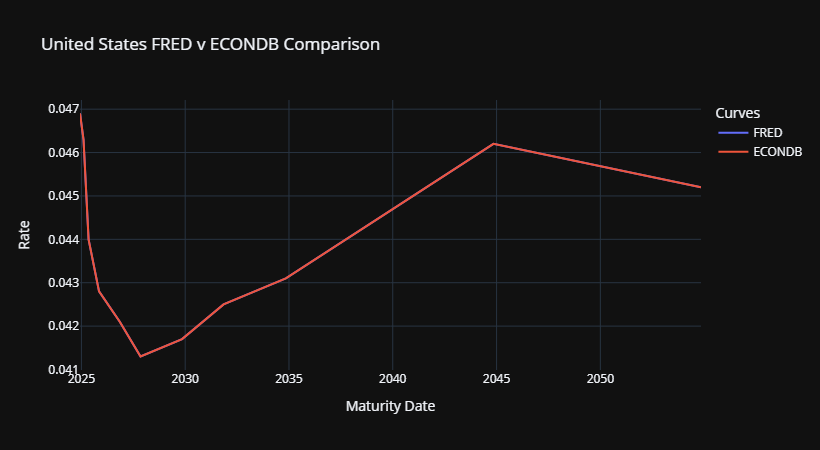

Okay so they are using the same data - ECONDB probably taken from FRED anyways but better safe to know incase other inputs or params are used

### Next want to see what expected inflation looks like between the real and nominal curves in the US using FRED

In [11]:
nom_yield_curve = obb.fixedincome.government.yield_curve(provider='fred', yield_curve_type='nominal', country='united_states')
df_nom = nom_yield_curve.to_df(index=False)

real_yield_curve = obb.fixedincome.government.yield_curve(provider='fred', yield_curve_type='real', country='united_states')
df_r = real_yield_curve.to_df(index=False)
df_r["maturity"] = df_r.apply(lambda row: get_maturity_date(row["maturity"], pd.to_datetime(row['date'])),axis=1)
df_r = df_r[['maturity','rate']] 

df_nom["maturity"] = df_nom.apply(lambda row: get_maturity_date(row["maturity"], pd.to_datetime(row['date'])),axis=1)
df_nom = df_nom[['maturity','rate']] 
df_nom

comp = pd.DataFrame(index=df_nom.index)
comp['Maturity'] = df_nom['maturity']
comp['US Real'] = df_r['rate']
comp['US Nominal'] = df_nom['rate']
comp['Implied Inflation'] = comp['US Nominal'] - comp['US Real']

comp = comp.dropna() # There a number of rows that the US Real is not receiving in
comp

,Maturity,US Real,US Nominal,Implied Inflation
0,2024-12-07,0.0177,0.0469,0.0292
1,2025-02-07,0.0187,0.0463,0.0276
2,2025-05-07,0.0198,0.0440,0.0242
3,2025-11-07,0.0214,0.0428,0.0214
4,2026-11-07,0.0222,0.0421,0.0199


In [12]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=comp['Maturity'], y=comp['US Real'], mode='lines', name='US Real', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=comp['Maturity'], y=comp['US Nominal'], mode='lines', name='US Nominal', line=dict(color='green')))
fig.add_trace(go.Scatter(x=comp['Maturity'], y=comp['Implied Inflation'], mode='lines', name='Implied Inflation', line=dict(color='red', dash='dot')))

fig.update_layout(
    title="United States Real vs Nominal vs Implied Inflation",
    xaxis_title="Maturity Date",
    yaxis_title="Rate",
    legend_title="Curves",
    template="plotly_dark",
    yaxis=dict(title="Rates", range=[0, max(comp[['US Real', 'US Nominal']].max()) * 1.1]),
    xaxis=dict(tickformat="%Y-%m-%d")
)

fig.show()

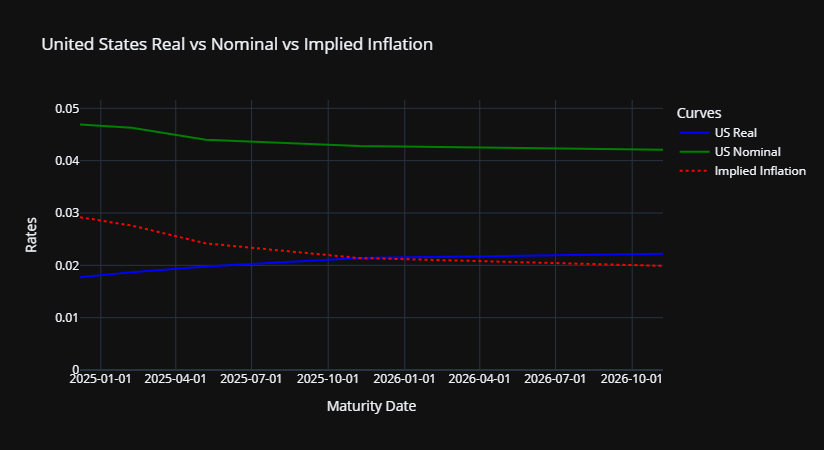


## Treasury Prices

Looking at the Treasury Prices function, we can see that it provides the below data, we have the option of 2 different providers, I used government_us

In [ ]:
t_prices = obb.fixedincome.government.treasury_prices(provider='government_us')
t_prices.to_df()


,cusip,security_type,maturity_date,bid,offer,eod_price,rate
date,,,,,,,
2024-11-08,912797LD7,MARKET BASED BILL,2024-11-14,0.000000,99.925333,0.0,0.000000
2024-11-08,912797MC8,MARKET BASED BILL,2024-11-19,99.863111,99.862500,0.0,0.000000
2024-11-08,912797LE5,MARKET BASED BILL,2024-11-21,99.838764,99.838222,0.0,0.000000
2024-11-08,912797MD6,MARKET BASED BILL,2024-11-26,99.775500,99.775000,0.0,0.000000
2024-11-08,912797HP5,MARKET BASED BILL,2024-11-29,99.738667,99.738083,0.0,0.000000
...,...,...,...,...,...,...,...
2024-11-08,91282CJD4,MARKET BASED FRN,2025-10-31,99.974569,99.952645,0.0,0.047381
2024-11-08,91282CJU6,MARKET BASED FRN,2026-01-31,100.061072,100.034182,0.0,0.048143
2024-11-08,91282CKM2,MARKET BASED FRN,2026-04-30,99.943191,99.898661,0.0,0.047177


### We have MBB's and FRN's I can tell the difference has to do with the rate/dicounts, but need to read up on it.

I found that MBBs are typically used for short term, FRNs more so medium-term typically used in rising interest rate envorinments.

- FRN's - floating rate, paid Q
- MBB's - no interest, discount based - mores sensitive to changes


In [119]:
from datetime import datetime

t_df = t_prices.to_df()
t_df = t_df[t_df['security_type'] == 'MARKET BASED BILL']
t_df = t_df[1:]
t_df['maturity_date'] = pd.to_datetime(t_df['maturity_date'])

t_df['days_to_maturity'] = t_df.apply(lambda row: (row['maturity_date'] - pd.Timestamp(row.name)).days, axis=1)
t_df['calculated_yield'] = ((100 - t_df['offer']) / 100) * (360 / t_df['days_to_maturity'])
t_df['bond_equivalent_yield'] = ((100 - t_df['bid']) / t_df['bid']) * (360 / t_df['days_to_maturity'])

t_df.head()

,cusip,security_type,maturity_date,bid,offer,eod_price,rate,days_to_maturity,calculated_yield,bond_equivalent_yield
date,,,,,,,,,,
2024-11-08,912797MC8,MARKET BASED BILL,2024-11-19,99.863111,99.862500,0.0,0.0,11,0.0450,0.044861
2024-11-08,912797LE5,MARKET BASED BILL,2024-11-21,99.838764,99.838222,0.0,0.0,13,0.0448,0.044722
2024-11-08,912797MD6,MARKET BASED BILL,2024-11-26,99.775500,99.775000,0.0,0.0,18,0.0450,0.045001
2024-11-08,912797HP5,MARKET BASED BILL,2024-11-29,99.738667,99.738083,0.0,0.0,21,0.0449,0.044917
2024-11-08,912797ME4,MARKET BASED BILL,2024-12-03,99.688194,99.687500,0.0,0.0,25,0.0450,0.045041


In [121]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=t_df['maturity_date'], y=t_df['calculated_yield'], mode='markers+lines', 
                         name='Calculated Yield', marker=dict(color='blue'), line=dict(color='blue')))

fig.add_trace(go.Scatter(x=t_df['maturity_date'], y=t_df['bond_equivalent_yield'], mode='markers+lines', 
                         name='Bond-Equivalent Yield', marker=dict(color='green'), line=dict(color='green')))

fig.update_layout(
    title="Yield Curve for T-Bills",
    xaxis_title="Maturity Date",
    yaxis_title="Yield (%)",
    legend=dict(x=0.1, y=0.9),
    template="plotly_white"
)

fig.show()

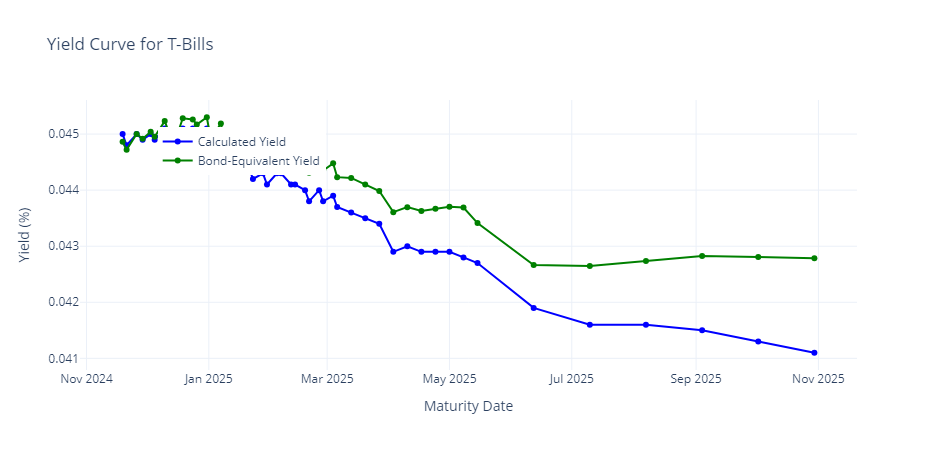

## Pulling Treasury Rates to Validate 

In [122]:
t_rates = obb.fixedincome.government.treasury_rates(provider='federal_reserve')
t_rates = t_rates.to_df()
t_rates

,month_1,month_3,month_6,year_1,year_2,year_3,year_5,year_7,year_10,year_20,year_30
date,,,,,,,,,,,
2023-11-10,0.0553,0.0553,0.0546,0.0538,0.0504,0.0480,0.0465,0.0468,0.0461,0.0493,0.0473
2023-11-13,0.0553,0.0555,0.0548,0.0537,0.0502,0.0480,0.0466,0.0469,0.0463,0.0495,0.0475
2023-11-14,0.0552,0.0552,0.0541,0.0524,0.0480,0.0456,0.0442,0.0445,0.0444,0.0480,0.0461
2023-11-15,0.0552,0.0553,0.0541,0.0527,0.0490,0.0468,0.0452,0.0456,0.0453,0.0487,0.0468
2023-11-16,0.0553,0.0551,0.0538,0.0523,0.0483,0.0459,0.0443,0.0447,0.0445,0.0482,0.0463
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,0.0475,0.0461,0.0442,0.0428,0.0421,0.0418,0.0422,0.0430,0.0437,0.0468,0.0457
2024-11-04,0.0475,0.0465,0.0439,0.0425,0.0417,0.0410,0.0417,0.0424,0.0431,0.0460,0.0450
2024-11-05,0.0472,0.0464,0.0439,0.0427,0.0419,0.0411,0.0416,0.0422,0.0426,0.0455,0.0444


It looks like they are providing a table of historical yields and their respective maturity dates. 

I am going to try strip the last row and fit that to our us Yield Curve graph made earlier and see how it aligns

In [123]:
t_slice = t_rates.iloc[-1]
t_slice_df = t_slice.to_frame()
t_slice_df = t_slice_df.reset_index(drop=False)

start_date = t_slice_df.columns[1] # I need to save this date so we can use the get_maturity function again

t_slice_df.columns = ['maturity', 'rate']
t_slice_df

,maturity,rate
0,month_1,0.0469
1,month_3,0.0463
2,month_6,0.0440
3,year_1,0.0428
4,year_2,0.0421
5,year_3,0.0413
6,year_5,0.0417
7,year_7,0.0425
8,year_10,0.0431
9,year_20,0.0462


In [124]:
t_slice_df["maturity"] = t_slice_df.apply(lambda row: get_maturity_date(row["maturity"], pd.to_datetime(start_date)),axis=1)
t_slice_df

,maturity,rate
0,2024-12-07,0.0469
1,2025-02-07,0.0463
2,2025-05-07,0.0440
3,2025-11-07,0.0428
4,2026-11-07,0.0421
5,2027-11-07,0.0413
6,2029-11-07,0.0417
7,2031-11-07,0.0425
8,2034-11-07,0.0431
9,2044-11-07,0.0462


Great so we have a DF that we can map to the older Yield curve used and see if there are any variances

In [125]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['maturity'], y=df['rate'], mode='lines', name='FRED'))
fig.add_trace(go.Scatter(x=df_econ['maturity'], y=df_econ['rate'], mode='lines', name='ECONDB'))
fig.add_trace(go.Scatter(x=t_slice_df['maturity'], y=t_slice_df['rate'], mode='lines', name='T Bill Rates'))

fig.update_layout(
    title="United States FRED v ECONDB Comparison",
    xaxis_title="Maturity Date",
    yaxis_title="Rate",
    legend_title="Curves",
    template="plotly_dark"
)

fig.show()

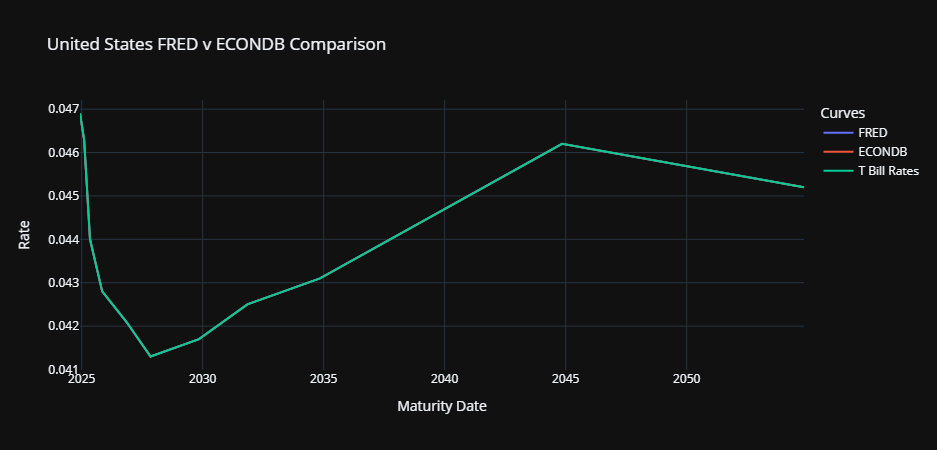

### T-Bill rates have been puled correctly and match the FRED and ECONDB

I am going to now add the calculated yields we got from the T Bill Prices to see if ther eis a major difference

In [127]:
end_date = start_date + pd.DateOffset(years=2)
start_date = t_df['maturity_date'].min()

t_df['maturity_date'] = pd.to_datetime(t_df['maturity_date'])
df['maturity'] = pd.to_datetime(df['maturity'])
df_econ['maturity'] = pd.to_datetime(df_econ['maturity'])
t_slice_df['maturity'] = pd.to_datetime(t_slice_df['maturity'])

df_filtered = df[(df['maturity'] >= start_date) & (df['maturity'] <= end_date)]
df_econ_filtered = df_econ[(df_econ['maturity'] >= start_date) & (df_econ['maturity'] <= end_date)]
t_slice_df_filtered = t_slice_df[(t_slice_df['maturity'] >= start_date) & (t_slice_df['maturity'] <= end_date)]
t_df_filtered = t_df[(t_df['maturity_date'] >= start_date) & (t_df['maturity_date'] <= end_date)]


fig = go.Figure()

fig.add_trace(go.Scatter(x=df_filtered['maturity'], y=df_filtered['rate'], mode='lines', name='FRED'))
fig.add_trace(go.Scatter(x=df_econ_filtered['maturity'], y=df_econ_filtered['rate'], mode='lines', name='ECONDB'))
fig.add_trace(go.Scatter(x=t_slice_df_filtered['maturity'], y=t_slice_df_filtered['rate'], mode='lines', name='T Bill Rates'))
fig.add_trace(go.Scatter(x=t_df_filtered['maturity_date'], y=t_df_filtered['calculated_yield'], mode='lines', name='T Bill C Rates'))

fig.update_layout(
    title="Rates Comparison",
    xaxis_title="Maturity Date",
    yaxis_title="Rate",
    legend_title="Curves",
    template="plotly_dark"
)

fig.show()

C:\Users\devon\AppData\Local\Temp\ipykernel_17980\1484958213.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



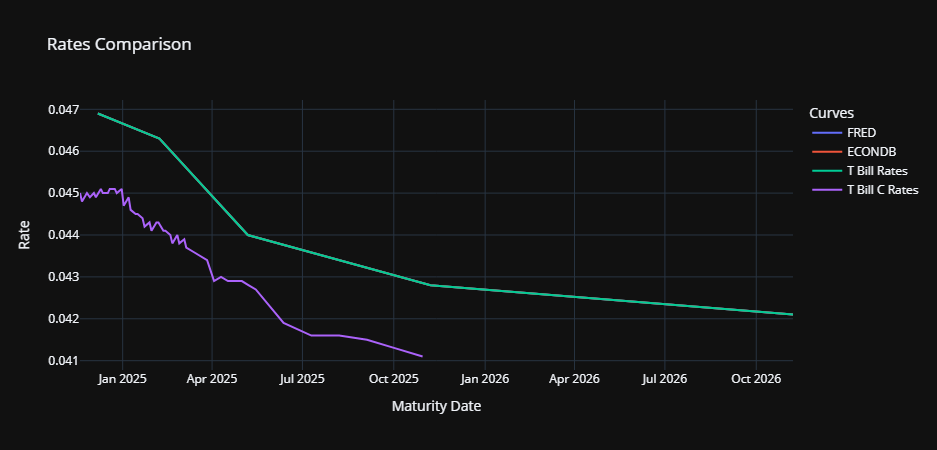

The graph shows that all rates published are the same, our calculated T bill rate from the T bill prices are different.

This difference makes sense in the rate cutting environment currently as there is a greater demand for these T bills and a consensus on priced in future rate cuts

I am happy with what I have found and the uses so far and will begin looking at the corporate submodule of OpenBB